#  Duffing model generator usage example

Demonstrating transmon model generator usage

In [1]:
# general libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# qiskit and pulse stuff
import qiskit
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

# new model generator function
from qiskit.providers.aer.openpulse.duffing_model_generators import duffing_system_model

## Specify system model

Parameters here are based on `FakeOpenPulse2Q` so that the schedules from that notebook can be used here

In [2]:
# number of qubits and cutoff dimensions
dim_oscillators = 3

# frequencies for duffing drift terms, harmonic term and anharmonic term
oscillator_freqs = [5.0, 5.1]
anharmonicity_freqs = [-0.33, -0.33]

# oscillator drive strengths
drive_strengths = [0.02, 0.02]

# specify coupling as a dictionary (it says qubits 0 and 1 are coupled with a coefficient 0.02)
coupling_dict = {(0,1): 0.01}

# time 
dt = 1.

# create the model
system_model, cr_idx_dict = duffing_system_model(dim_oscillators=dim_oscillators,
                                                  oscillator_freqs=oscillator_freqs,
                                                  anharm_freqs=anharmonicity_freqs,
                                                  drive_strengths=drive_strengths,
                                                  coupling_dict=coupling_dict,
                                                  dt=dt)

The returned items are: 
- `system_model`, an instance of `PulseSystemModel` consumable by the simulator representing the specified transmon system model. 
- `cr_idx_dict`, a dict storing information on the index of the channel for a given CR drive. Specifically, when two qubits are coupled in the model, two CR drive channels are created for doing CR drives in both directions, and `cr_idx_dict` keeps track of the indices for these channels. E.g. in the above we specified the coupling `(0,1)`. When performing a CR drive on qubit 0 with target 1, use u channel with index `cr_idx_dict[(0,1)]`, and when performing a CR drive on qubit 1 with target 0, use u channel with index `cr_idx_dict[(1,0)]`

# Do Rabi experiment from previous example notebook using this model

## First set up schedules

In [3]:
#qubit to use for exeperiment
qubit = 0
# exp configuration
exps = 41
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 0.9, exps)
drive_samples = 128
drive_sigma = 16

# Measurement pulse
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25

# Measurement pulse (common for all experiment)
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                       sigma=meas_sigma, risefall=meas_risefall, 
                                       name='meas_pulse')
acq_cmd=pulse.Acquire(duration=meas_samples)

acquire_channels = [pulse.AcquireChannel(0), pulse.AcquireChannel(1)]
memoryslots = [pulse.MemorySlot(0), pulse.MemorySlot(1)]

# create measurement schedule
measure_and_acquire = meas_pulse(pulse.MeasureChannel(0)) | acq_cmd(acquire_channels, memoryslots)

# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                    amp=drive_amp, 
                                    sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='rabi_exp_amp_%s' % drive_amp)
    
    schedule += rabi_pulse(pulse.DriveChannel(0))
    schedule += measure_and_acquire << schedule.duration
 
    schedules.append(schedule)

## Set up simulation

In [4]:
# import simulator
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

# construct qobj. In this case we want to use channel frequencies computed directly from the Hamiltonian
qubit_lo_freq = system_model.hamiltonian.get_qubit_lo_from_drift()
rabi_qobj = assemble(schedules,
                     backend=backend_sim,
                     qubit_lo_freq=qubit_lo_freq,
                     meas_level=1, 
                     meas_return='avg', 
                     memory_slots=2,
                     shots=shots)

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:166: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '


## Run simulation

In [5]:
sim_result = backend_sim.run(rabi_qobj, system_model).result()

## Extract results and plot

Pi Amplitude 0.316382


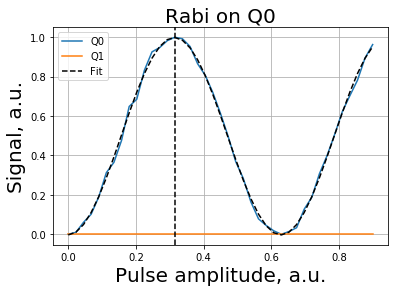

In [6]:
amp_data_Q0 = []
amp_data_Q1 = []

for exp_idx in range(len(drive_amps)):
    exp_mem = sim_result.get_memory(exp_idx)
    amp_data_Q0.append(np.abs(exp_mem[0]))
    amp_data_Q1.append(np.abs(exp_mem[1]))
    
#Fit the data
fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
fitparams, conv = curve_fit(fit_func, drive_amps, amp_data_Q0, [0.5,0.5,0.6,1.5])

#get the pi amplitude
pi_amp = (fitparams[3])*fitparams[2]/2/np.pi

plt.plot(drive_amps, amp_data_Q0, label='Q0')
plt.plot(drive_amps, amp_data_Q1, label='Q1')
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='black', linestyle='dashed', label='Fit')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.legend()
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rabi on Q0', fontsize=20)
plt.grid(True)

print('Pi Amplitude %f'%(pi_amp))

# Cross-Resonance

Run the cross resonance (demonstrate usage of `cr_idx_dict`)

In [7]:
#qubit to use for experiment
target_qubit = 0
driven_qubit = 1

# drive qubit 1 with target 0
cr_idx = cr_idx_dict[(driven_qubit, target_qubit)]


# exp configuration
exps = 41
shots = 512

# Rabi pulse
cr_drive_amps = np.linspace(0, 0.9, exps)
cr_drive_samples = 128*3
cr_drive_sigma = 4


# Create schedule
schedules = []
for ii, cr_drive_amp in enumerate(cr_drive_amps):
    # drive pulse
    cr_rabi_pulse = pulse_lib.gaussian_square(duration=cr_drive_samples, 
                                    amp=cr_drive_amp, 
                                    risefall=cr_drive_sigma*4,
                                    sigma=cr_drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='cr_rabi_exp_amp_%s' % cr_drive_amp)
    
    schedule += cr_rabi_pulse(pulse.ControlChannel(cr_idx))
    schedule += measure_and_acquire << schedule.duration
 
    schedules.append(schedule)

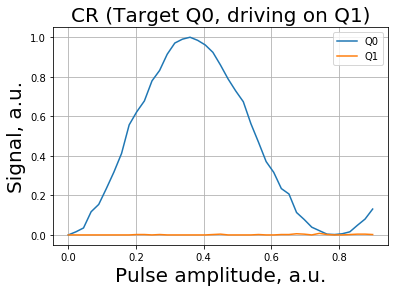

In [8]:
# assemble, run experiment, plot data
cr_rabi_qobj = assemble(schedules, 
                        qubit_lo_freq=qubit_lo_freq,
                        backend=backend_sim,
                        meas_level=1, 
                        meas_return='avg', 
                        memory_slots=2,
                        shots=shots)
sim_result = backend_sim.run(cr_rabi_qobj, system_model).result()

amp_data_Q0 = []
amp_data_Q1 = []

for exp_idx in range(len(cr_drive_amps)):
    exp_mem = sim_result.get_memory(exp_idx)
    amp_data_Q0.append(np.abs(exp_mem[0]))
    amp_data_Q1.append(np.abs(exp_mem[1]))
    

plt.plot(drive_amps, amp_data_Q0, label='Q0')
plt.plot(drive_amps, amp_data_Q1, label='Q1')
plt.legend()
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('CR (Target Q{0}, driving on Q{1})'.format(str(target_qubit),str(driven_qubit)), fontsize=20)
plt.grid(True)